# Poisson equation on an L-shaped domain

Solve

\[
- \Delta u = f \quad\text{in }\Omega
\]

with \(\Omega\) being an L-shaped domain, Dirichlet boundary \(u=0\) on the entire boundary, and right-hand side \(f(x,y)\).

We'll:
1. Build a gmsh mesh of the L-shaped domain.
2. Convert to XDMF (meshio).
3. Read into dolfinx and solve.
4. Visualize with pyvista.

In [32]:
# If you need to install packages in a notebook environment, uncomment and run.
# Be careful: installing dolfinx in-notebook is not trivial on every system.
# !pip install gmsh meshio pyvista meshio-xdmf pyvistaqt

# Imports
import gmsh

import numpy as np
from mpi4py import MPI

import dolfinx
import meshio
from dolfinx import mesh as dmesh
from dolfinx import *
from dolfinx.fem import  dirichletbc, locate_dofs_topological
from dolfinx.mesh import locate_entities_boundary
from dolfinx.io import XDMFFile
import ufl
from petsc4py import PETSc

from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, set_bc

# Visualization
import pyvista as pv



In [33]:
# Geometry parameters
Lx, Ly, Lx2, Ly2 = 4.0, 7.0, 2.0, 1.5   # L-shape size
nx, ny = 40, 20     # mesh divisions (controls resolution)

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("L_shape")

# corner points for L-shape
p1 = gmsh.model.geo.addPoint(0.0, 0.0, 0.0)
p2 = gmsh.model.geo.addPoint(Lx, 0.0, 0.0)
p3 = gmsh.model.geo.addPoint(Lx, Ly2, 0.0)
p4 = gmsh.model.geo.addPoint(Lx2, Ly2, 0.0)
p5 = gmsh.model.geo.addPoint(Lx2, Ly, 0.0)
p6 = gmsh.model.geo.addPoint(0.0, Ly, 0.0)

# lines
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p5)
l5 = gmsh.model.geo.addLine(p5, p6)
l6 = gmsh.model.geo.addLine(p6, p1)

cl = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4, l5, l6])
surf = gmsh.model.geo.addPlaneSurface([cl])

# mesh size control (simple uniform)
# set a characteristic length near each point
#for p in (p1, p2, p3, p4, p5, p6):
#    gmsh.model.geo.setPointMeshSize(p, max(Lx/nx, Ly/ny))

gmsh.model.geo.synchronize()

# Physical group for the surface (required to preserve tags)
gmsh.model.addPhysicalGroup(2, [surf], tag=1)
gmsh.model.setPhysicalName(2, 1, "Domain")

# Physical group for boundary (all boundary lines)
gmsh.model.addPhysicalGroup(1, [l1, l2, l3, l4, l5, l6], tag=2)
gmsh.model.setPhysicalName(1, 2, "Boundary")

# Generate mesh (2D triangular)
gmsh.model.mesh.generate(2)

# Save mesh
msh_filename = "L_shape.msh"
gmsh.write(msh_filename)
print(f"Saved mesh to {msh_filename}")

# finalize gmsh
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.000169416s, CPU 0.000331s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000504083s, CPU 0.000758s)
Info    : 54 nodes 112 elements
Info    : Writing 'L_shape.msh'...
Saved mesh to L_shape.msh
Info    : Done writing 'L_shape.msh'


In [34]:
from dolfinx.io import gmshio

mesh, cell_tags, facet_tags = gmshio.read_from_msh(
    "L_shape.msh",
    MPI.COMM_WORLD,
    gdim=2
)

print("Mesh loaded directly from gmsh:")
print("  cells:", mesh.topology.index_map(mesh.topology.dim).size_local)
print("  vertices:", mesh.topology.index_map(0).size_local)

Info    : Reading 'L_shape.msh'...
Info    : 13 entities
Info    : 54 nodes
Info    : 106 elements
Info    : Done reading 'L_shape.msh'
Mesh loaded directly from gmsh:
  cells: 77
  vertices: 54


In [35]:
# Function space (first-order Lagrange, CG1)
V = fem.functionspace(mesh, ("CG", 1))

# Trial / Test
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Right-hand side f = 1 (UFL scalar constant)
f = dolfinx.fem.Constant(mesh, 1.0)

# Variational forms
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

# --- Dirichlet BC: u=0 on whole boundary ---
# Use facet tags from gmsh physical group
facet_indices = facet_tags.find(2)
print("boundary facets (local):", len(facet_indices))

# locate dofs on those facets
dofs = locate_dofs_topological(V, mesh.topology.dim - 1, facet_indices)
u0 = fem.Function(V)
u0.x.array[:] = 0.0

bc = dirichletbc(u0, dofs)

boundary facets (local): 29


In [36]:
# forms
a_form = fem.form(a)
L_form = fem.form(L)

# assemble matrix & vector (PETSc objects)
A = assemble_matrix(a_form, bcs=[bc])
A.assemble()
b = assemble_vector(L_form)

# apply lifting & bc corrections
apply_lifting(b, [a_form], bcs=[[bc]])
b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
set_bc(b, [bc])

# create solution function
uh = fem.Function(V)

# --- Robust solve (dolfinx 0.9.0 friendly) ---
from petsc4py import PETSc


# assume A (PETSc.Mat) and b (PETSc.Vec) exist, and uh = fem.Function(V) exists

# 1) create solution PETSc Vec with same layout as b
x_petsc = b.duplicate()   # same parallel layout as b, all zeros

# 2) Setup KSP and solve
ksp = PETSc.KSP().create(MPI.COMM_WORLD)
ksp.setOperators(A)
ksp.setType("cg")
# try AMG / hypre preconditioner if available
try:
    ksp.getPC().setType("hypre")
except Exception:
    pass
ksp.setFromOptions()

ksp.solve(b, x_petsc)   # solve A x = b

# 3) copy PETSc solution into dolfinx Function storage
# Get numpy array from PETSc Vec (local ordering)
sol_local = x_petsc.getArray()

# uh.x.array is the dolfinx local-array backing the Function (common in 0.9.0)
# We must be careful: uh.x.array length should match sol_local length (local dofs)
try:
    uh.x.array[:] = sol_local
except Exception:
    # If direct copy fails, try a more defensive approach:
    #  - get sizes, copy minimum length
    try:
        dst = uh.x.array
        nmin = min(dst.size, sol_local.size)
        dst[:nmin] = sol_local[:nmin]
        uh.x.array[:] = dst
    except Exception as e:
        raise RuntimeError("Failed to copy PETSc Vec into uh.x.array: " + str(e))

# 4) make sure ghost values are updated / consistent
# Try common methods: scatter_forward or ghostUpdate
try:
    uh.x.scatter_forward()   # common in many dolfinx builds
except Exception:
    try:
        uh.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    except Exception:
        # If neither exists, it's likely fine (values are in uh.x.array), but warn:
        print("Warning: could not run a ghost/scatter forward. Values set in uh.x.array may need updating.")

# Final quick check: norm
try:
    sol_array = uh.x.array
except Exception:
    sol_array = sol_local  # fallback

print("Solved. local solution length:", sol_array.size, "||u||_2 (local) =", np.linalg.norm(sol_array))



Solved. local solution length: 54 ||u||_2 (local) = 1.7515113489323946


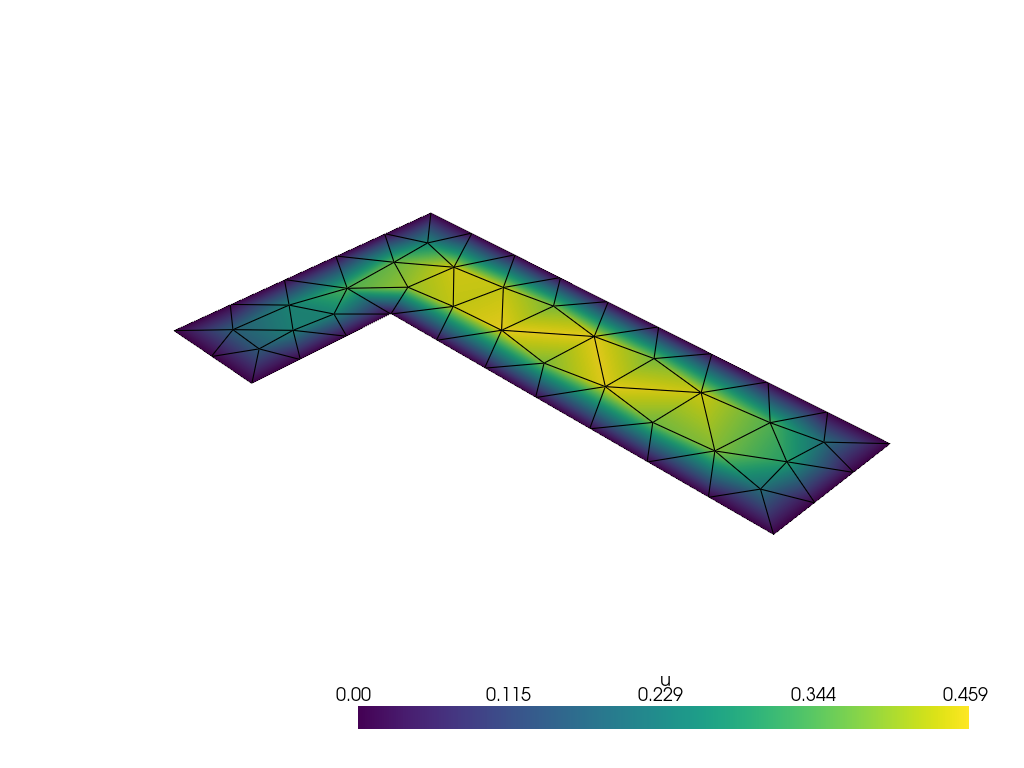

In [37]:
# Visualization with pyvista

# get coordinates (global)
coords = mesh.geometry.x.copy()   # (num_vertices, gdim)
coords = np.array(coords)         # ensure numpy array
num_vertices_per_cell = mesh.topology.dim + 1  # triangles -> 3
# get cell->vertex connectivity for triangles
top = mesh.topology.connectivity(mesh.topology.dim, 0)
conn = top.array.reshape((-1, num_vertices_per_cell))  # cells x num_vertices_per_cell
cells = conn.astype(np.int64)

# build pyvista cell array format
n_cells = cells.shape[0]
cell_types = np.full(n_cells, pv.CellType.TRIANGLE, dtype=np.uint8)
cells_pv = np.hstack([np.full((n_cells, 1), num_vertices_per_cell, dtype=np.int64), cells]).flatten()

grid = pv.UnstructuredGrid(cells_pv, cell_types, coords)
# attach solution at nodal points if number of points matches
if coords.shape[0] == sol_array.shape[0]:
    grid["u"] = sol_array
else:
    # might be cell-wise: attach cell data
    if sol_array.shape[0] == n_cells:
        grid.cell_data["u"] = sol_array
    else:
        print("Mismatch between dofs and points — skip attaching data")

p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars="u", show_edges=True)
p.add_scalar_bar("u")
p.show()
